In [1]:
from langfuse import get_client
import json
from dotenv import load_dotenv
from datetime import datetime, timezone

load_dotenv()  # Load environment variables from .env file


True

In [2]:
import time
import random
try:
    from langfuse import ApiError
except ImportError:
    # Fallback - try different import paths
    try:
        from langfuse.client import ApiError  
    except ImportError:
        print("ApiError not found, mocking")
        # Create a generic exception class if we can't find the right one
        class ApiError(Exception):
            def __init__(self, status_code, body):
                self.status_code = status_code
                self.body = body
                super().__init__(f"API Error {status_code}: {body}")

ApiError not found, mocking


In [13]:
def fetch_trace_with_retry(langfuse_client, trace_id, max_retries=3, base_delay=1.0):
    """Fetch trace with exponential backoff retry logic"""
    for attempt in range(max_retries):
        try:
            return langfuse_client.api.trace.get(trace_id)
        except Exception as e:
            # Check if it's a rate limit error (429)
            is_rate_limit = False
            if hasattr(e, 'status_code') and e.status_code == 429:
                is_rate_limit = True
            elif 'rate limit' in str(e).lower() or '429' in str(e):
                is_rate_limit = True
                
            if is_rate_limit:
                if attempt < max_retries - 1:
                    # Exponential backoff with jitter
                    delay = (base_delay * (2 ** attempt)) + random.uniform(0, 1)
                    print(f"Rate limited, retrying in {delay:.2f}s (attempt {attempt + 1}/{max_retries})",end='\r')
                    time.sleep(delay)
                    continue
                else:
                    print(f"Max retries exceeded for trace {trace_id}")
                    return None
            else:
                # Re-raise non-rate-limit errors immediately
                print(f"Non-rate-limit error for trace {trace_id}: {str(e)}")
                raise Exception(f"Error fetching trace {trace_id}: {str(e)}")
    return None

In [4]:
langfuse = get_client()
if langfuse.auth_check():
    print("Successfully authenticated with Langfuse.")
else:
    print("Failed to authenticate with Langfuse. Please check your API key and connection.")


Successfully authenticated with Langfuse.


In [ ]:

start_time = datetime.fromisoformat("2026-02-03T14:00:17.137054+00:00")
end_time = datetime.fromisoformat("2026-02-10T07:46:32.934946+00:00")

all_traces = []
found = False
page = 15
limit_per_page = 100

In [15]:
print("Fetching traces...")
while True:
    # Fetch traces with pagination
    traces_response = langfuse.api.trace.list(limit=limit_per_page, page=page)
    
    if not traces_response.data:
        break
        
    # Filter traces by date range
    filtered_traces = [
        trace for trace in traces_response.data
        if start_time <= datetime.fromisoformat(trace.createdAt) <= end_time
    ]
    if filtered_traces:
        found = True
    
    all_traces.extend(filtered_traces)
    print(f"Page {page}: Found {len(filtered_traces)} traces in date range ({len(traces_response.data)} total on page)")
    
    if found and len(filtered_traces) == 0:
        break
        
    page += 1


if len(all_traces) == 0:
    print(f"No traces found in Langfuse between {start_time} and {end_time}. Please check the date range and try again.")
else:
    print(f"Total traces found in date range: {len(all_traces)}")

Fetching traces...
Page 26: Found 0 traces in date range (100 total on page)
Total traces found in date range: 933


In [22]:
results = []
att_error_count = 0
failed_fetches = 0
models = set()
frameworks = set()


In [23]:
start = 0

print(f"Processing {len(all_traces)} traces with rate limiting...")

for idx, trace in enumerate(all_traces):
    if idx < start:
        continue
    # Add delay between requests to avoid rate limits
    if idx > 0 and idx % 5 == 0:  # Every 10 requests
        time.sleep(0.4)  # Small delay to be respectful to API
        
    try:
        full_trace = fetch_trace_with_retry(langfuse, trace.id, max_retries=3)
    except Exception as e:
        print(f"failed on {idx}")
        exit(1)
    if full_trace is None:
        failed_fetches += 1
        continue
        
    metadata = trace.metadata
    model = metadata.get('model')
    framework = metadata.get('framework')
    if model:
        models.add(model)
    if framework:
        frameworks.add(framework)
    tool_calls_v1 = [obs.output.get("tool_calls") for obs in full_trace.observations 
                          if type(obs.output)== dict and obs.output.get("tool_calls")]
    tool_calls_v2 = [obs.output[0].get("tool_calls") for obs in full_trace.observations 
                          if type(obs.output)== list and obs.output and type(obs.output[0])== dict and obs.output[0].get("tool_calls")]
    
    tool_calls = len([call for call in tool_calls_v1 if call]) + len([call for call in tool_calls_v2 if call])
    

    results.append({
        'task_id': trace.id,
        'model': model,
        'framework': framework,
        'tool_calls': tool_calls
    })
    
    if (idx + 1) % 50 == 0:
        print(f"Processed {idx + 1}/{len(all_traces)} traces, with {att_error_count + failed_fetches} issues...")

print(f"Total traces processed: {len(all_traces)}")
print(f"Traces with attribute errors: {att_error_count}")
print(f"Failed fetches: {failed_fetches}")

Processing 933 traces with rate limiting...
Non-rate-limit error for trace d715e85d68c16d98fa1e1d510383f537: The read operation timed out
failed on 1
Non-rate-limit error for trace a35c58f7d6cb6c48f7f3168af140b182: [Errno -3] Temporary failure in name resolution
failed on 2
Non-rate-limit error for trace af14b683d64d42fb364955fe77aafad7: The read operation timed out
failed on 5
Non-rate-limit error for trace 91554ac0bc49e7c0dc5f006e56ce314e: The read operation timed out
failed on 10
Non-rate-limit error for trace 43945a8473f9f5a13ab6559977b7f7c1: The read operation timed out
failed on 11
Non-rate-limit error for trace 5d6bf855939e4de1fb63c086048dbe2e: The read operation timed out
failed on 14
Non-rate-limit error for trace 6074342b40408bb9a7640b30e68e3280: The read operation timed out
failed on 16
Non-rate-limit error for trace 0ca9d6ca67e05f95347852f4681eb67e: The read operation timed out
failed on 29
Non-rate-limit error for trace 9ff1fdbd44f86036a9c85d1fcd0d0c96: The read operation 

In [24]:
frameworks.discard(None)
frameworks.discard("crewai")
frameworks.discard("langchain")
agents = [f"{model} X {framework}" for model in models for framework in frameworks]
none_count = 0
analysed = {agent: 0 for agent in agents}
tool_calls = {agent: 0 for agent in agents}
for result in results:
    print( result)
    if result["framework"] in ["crewai","langchain"]:
        continue
    if not (result['model'] and result['framework']):
        none_count += 1
        print(f"Skipping for the {none_count} time due to missing model or framework: {result}")
        continue
    agent = f"{result['model']} X {result['framework']}"
    analysed[agent] += 1
    tool_calls[agent] += result['tool_calls']
average_tool_calls = {agent: (tool_calls[agent] / analysed[agent] if analysed[agent] > 0 else 0) for agent in agents}
for agent in agents:
    print(f"{agent}: Analysed {analysed[agent]} traces, Total Tool Calls: {tool_calls[agent]}, average tool calls per trace: {average_tool_calls[agent] :.2f}")
        

{'task_id': '071562b253a05a452f5a5c777658de27', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 6}
{'task_id': 'd715e85d68c16d98fa1e1d510383f537', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 6}
{'task_id': 'a35c58f7d6cb6c48f7f3168af140b182', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 6}
{'task_id': '30a702b41011e3d1fb19fca992ec3a9b', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 0}
{'task_id': '52d16429a86a175de1b27567da1020a7', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 11}
{'task_id': 'af14b683d64d42fb364955fe77aafad7', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 11}
{'task_id': '08f7715b79cc0cf816082e16fb13ca90', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 0}
{'task_id': 'fbdb7dcf156a9dc4c5e3f184173b37d5', 'model': 'gpt-oss-120b', 'framework': 'langgraph', 'tool_calls': 0}
{'task_id': '1d536bf38dbe33033544319a8126349b', 'model': 'gpt-oss-120b

Meta-Llama-3_3-70B-Instruct X langgraph: 2.37
Meta-Llama-3_3-70B-Instruct X openai_agents: 0.45
Mistral-Small-3.2-24B-Instruct-2506 X langgraph: 1.95
Mistral-Small-3.2-24B-Instruct-2506 X openai_agents: 1.47
gpt-oss-120b X langgraph: 4.11
gpt-oss-120b X openai_agents: 9.79
gpt-oss-20b X langgraph: 4.30
gpt-oss-20b X openai_agents: 11.06


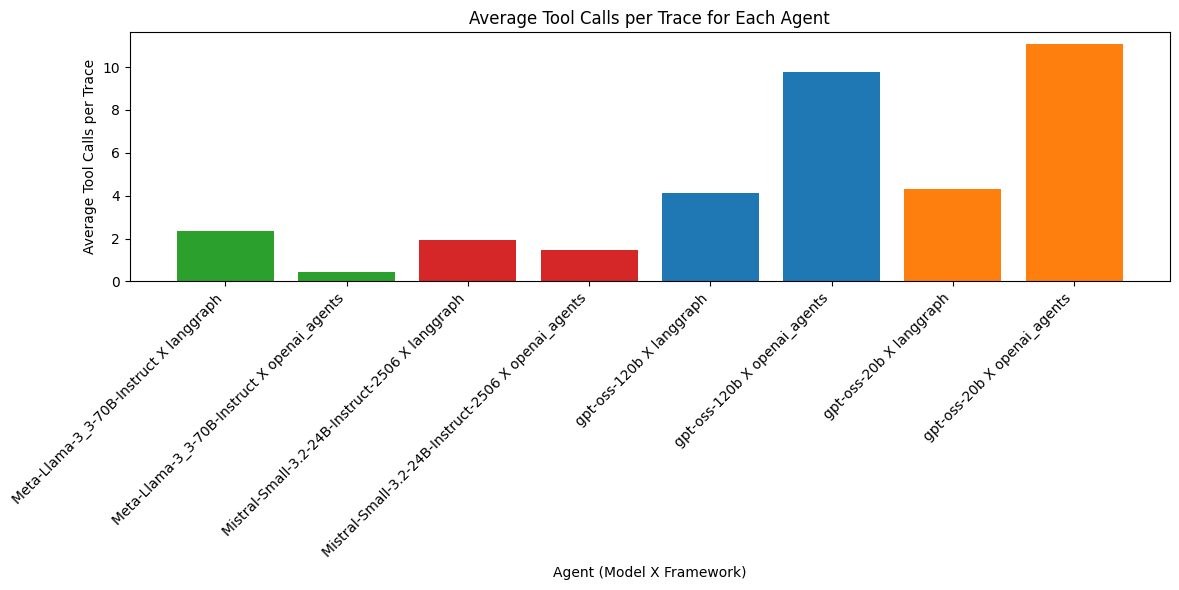

In [26]:
for agent, avg_calls in average_tool_calls.items():
    print(f"{agent}: {avg_calls:.2f}")
import matplotlib.pyplot as plt

model_colors = {
                'gpt-oss-120b': '#1f77b4',  # blue
                'gpt-oss-20b': '#ff7f0e',   # orange
                'Meta-Llama-3_3-70B-Instruct': '#2ca02c',        # green
                'Mistral-Small-3.2-24B-Instruct-2506': '#d62728'           # red
            }

fig = plt.figure(figsize=(12, 6))
# sort agents lexicographically for better visualization
average_tool_calls = dict(sorted(average_tool_calls.items(), key=lambda item: item[0]))
for agent, avg_calls in average_tool_calls.items():
    model_name = agent.split(" X ")[0]
    color = model_colors.get(model_name, 'gray')  # default to gray if model not in colors
    plt.bar(agent, avg_calls, color=color)
plt.xlabel('Agent (Model X Framework)')
plt.ylabel('Average Tool Calls per Trace')
plt.title('Average Tool Calls per Trace for Each Agent')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()